# Simple Example in Deployment in AI

This notebook gives you a simple example of how you can deploy a deep learning model via a RESTful service.  This does everything including training.
This notebook is running on a very average desktop with the following specifications:
- Intel i5 10500 (launched 2020)
- 32GB RAM
- 500GB SSD
- Nvidia 2060 super

## 2060 Super?
These cards are not expensive and not that powerful, they are so old now you can only get them on ebay.  You will also be able to get results on a 1060 which is even older and cheaper and I have seen this kind of thing working on a 980 which you can get for arround £30.  In terms of value I would suggest a 4060 TI, these are roughly £500 new and they come with 16GB of RAM, which is a lot for vision processing, you will easily be able to do tabular, visual, video, audio and some language processing with that.  Some of the LLM's need some very spicy hardware, we use A6000, but they are expensive.

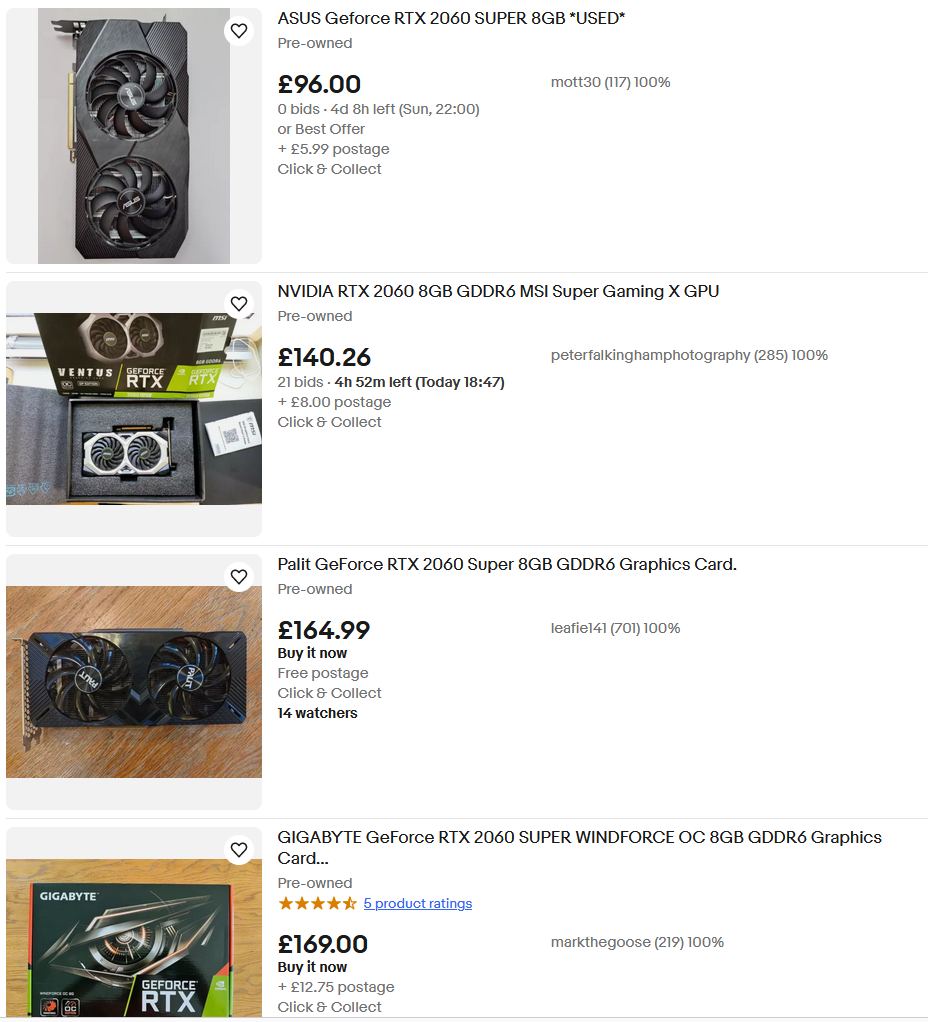

# Steps

1. Download the dataset
2. Unzip the files
3. Train
4. Pickle
5. Build Restful service
6. Use



# Step 0: Only for google colab
Install waitress

In [6]:
!pip install waitress

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 kB 1.2 MB/s eta 0:00:00


## Step 1: Download the dataset
The dataset used in this example is the Plant disease recognition dataset from Kaggle. You can download it here:

https://www.kaggle.com/datasets/rashikrahmanpritom/plant-disease-recognition-dataset

You will need to create an account to download data from Kaggle, place the file in the same directory as this file.

## Step 2: Unzip the files

In [3]:
!ls data

In [1]:
from zipfile import ZipFile

In [ ]:
with ZipFile("data/archive.zip", 'r') as z_object:
  z_object.extractall(path="data")

The files in this particular data set are in a strange format, with the Train directory having another Train directory in it. So let's sort this out and have one Train and one Valid directory

In [ ]:
!mv data/Train/Train/* data/Train
!mv data/Validation/Validation/* data/Validation
!rm -rf data/Train/Train data/Validation/Validation

## Step 3 Training

In [4]:
from fastai.vision.all import *
import pathlib

Let's have a look at the path data first and make sure the data is what we expect

In [ ]:
path= pathlib.Path('data')
path.ls()

We need a function to get the data, this returns a list of files, both training data and validation data

In [ ]:
def get_data(path):
  out = []
  dirs = ['Train', 'Validation']
  for directory in dirs:
    for class_name in (pathlib.Path(path)/directory).ls():
      for file_name in class_name.ls():
        out.append(file_name)

  return out

Let's test it out

In [ ]:
get_data(path)[0:10]

We need a function which for a given file (e.g. data/Train/Healthy/8cabfc30e0a380ff.jpg) and decide which class it belongs to

In [ ]:
def label_function(x):
  return x.parts[-2]

Let's test it out

In [ ]:
label_function(get_data(path)[0])

This section is a bit complicated. The DataBlock API is how fastai defines the structure of the data it will be processing, its output and where to get that data from. First a bit of bonkers terminlogy:

- x
- independent variable
- input

These are all the same thing, they are the thing that goes in the front of our process to generate the output on:

- y
- dependent variable
- output
- embedding (maybe, it does not mean this, but some people do call it this)
- y^ / y_hat (maybe)

These are also the same thing, they are the answer our process gives us at the end.  I prefer maths terminology so I will use X/Y

So going quickly though the API:
- blocks = This is the structure of X and Y as a tuple, so out X is an ImageBlock (ie an image), the Y is a CategoryBlock (ie a class)
- get_items = The function to be called to get a list of the values
- splitter = The function to be used to split data into the training and validation sets, for this data set I should really use a directory based splitter, but this is quicker
- get_y = A function which for the given input X will return the Y (ie for a given image return the class)
- item_tfms = Transformations which are run at an item level
- batch_tfms = Transformations which are run on a batch of data

You can also specify loss functions, by default it will use cross entropy loss, there might be other choices which are better for certain applications, but you can review those in your own time.

In [ ]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_data,
                 splitter=RandomSplitter(seed=42),
                 get_y=label_function,
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders('data')

Let's have a look at our data

In [ ]:
dls.show_batch(nrows=3, ncols=3)

So let's do some training, this is a vision problem, so we will need a vision learner, and we can use a pre-trained model, in this case resnet34, see here for more examples, but I choose resnet as a good starting point: https://fastai1.fast.ai/vision.models.html

WARNING: There is some irony in some model names, one thing EfficientNet is not is efficient!

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

We are only doing some fine tuning here, this will be enough to get an _acceptable_ level of accuracy in many situations, it is NOT going to get you a state of the art accuracy, but we are talking about getting something acceptable in a few hours vs. getting something amazing in a few weeks or months.  This is an example neural network:


![Neural Network](https://miro.medium.com/v2/resize:fit:2398/format:webp/1*N8UXaiUKWurFLdmEhEHiWg.jpeg)

Fine tuning will only work on that last layer, the one labled output layer.  There are lots of reasons why we do this and the process is called freezing and unfreezing in the context of Transfer Learning. We won't go into why this works or what it's for, but its sufficient to know that this will "do" for many applications. When you're able to do the ML pipeline yourself, then you should start to play with these concepts.

In [ ]:
learn.fine_tune(2)

We have run 2 epochs, that means out process has seen all of our data twice.  The process is:
- Process all data and calculate gradients
- Adjust the model to reduce the loss on the gradients

You can run the process for as many epochs as you wish to get the best answers, sometimes it will take 100's of epochs.

## Step 3 (and a bit): Review the results

For classification problems we can look at a confusion matrix, this shows the records in the validation set which is what our network predicted vs. what they actually are.  We want to see a diagnoal blue line which shows our network predicted the correct class, the other numbers represent the mistakes.  Remember, this is run on the validation data set, so this is data that the network did not train with.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

So this means, there are 93 Healthy, 97 Powdery and 81 Rust images which it got correct, it got 5 other images incorrect, most of which were predicted as healthy.  No AI is perfect, so I am going to mark this as "good enough" for our use case.

However, we can have a quick look at the ones that it got wrong.

In [ ]:
interp.plot_top_losses(9)

So looking at those 5 examples it got wrong, I can understand why and I would consider that an acceptable mistake, so let's proceed.


## Part 4 Pickle
We will save our work in a pickle file, this will include:
- The architecture
- The weights / biases
- The Datablock settings
- The references get_data and label_function, so at inference time you will need to be able to reference these functions (they won't need to do anything).

In [ ]:
learn.export('trained.pkl')

Now we have saved it, lets test it out with a few images-

In [ ]:
inference_engine = load_learner('trained.pkl')

In [ ]:
inference_engine.predict('data/Test/Test/Healthy/8ddaa5a5caa5caa8.jpg')

In [ ]:
inference_engine.predict('data/Test/Test/Powdery/83b96c056477bf11.jpg')

In [ ]:
inference_engine.predict('data/Test/Test/Rust/87e8cb11791fd078.jpg')

So to be clear what is going on here, the predict function is returning three values as a tuple:
- The Category Name
- A tensor representing the integer classification (if this gets you the results you need, don't worry about tensors)
- A tensor representing the embeddings at the output layer, (as above, don't worry about tensors unless you need to do more in depth stuff)

If we want to we can re-examine the saved category names in the data loader (dls)

In [ ]:
inference_engine.dls.vocab

## Use - RESTful

So we are going to build a RESTful service now, this will accept an input image that is PUT on /leafer, it will return with a simple class name.  This can then be integrated into your other applications.

In [ ]:
import flask
from waitress import serve
import uuid
import threading #We dont really need threadding here, but Scott likes to think he is clever.

This is our restful service, it has one method which is /leafer, when PUT is called on /leafer it will call the run_inference function.  This will save the file to the file system, then call predict on the file and return the label.  This can easily be implemented in a simple python script. Which you can then dockerise or deploy within some other bit of your infrastructure.

In [ ]:
class RestfulService():
  def __init__(self, model_file):
    self.inference_engine = load_learner(model_file, cpu=True)
    self.app = flask.Flask('Scotts Leafer')
    self.app.add_url_rule('/leafer', methods = ['PUT'], view_func = self.run_inference)

  def run_inference(self):
    temp_file = path/str(uuid.uuid4())
    try:
      with open(temp_file, 'wb') as file_handle:
        file_handle.write(flask.request.data)
      label, output_tensor, embedding = self.inference_engine.predict(temp_file)
      return label
    finally:
      temp_file.delete()

There are only 14 lines of code here and 6 of them are about writing the file to the file system, so you can create this restful service in about 10 lines of code.

In [ ]:
def start_serving():
  restful_service = RestfulService('trained.pkl')
  serve(restful_service.app, host="0.0.0.0", port=5000)

http_thread = threading.Thread(target=start_serving)
http_thread.start()

We now have a RESTful service running on port 5000, which we can call via whatever REST clients. So let's head over to postman now for one that I did not prepare earlier.